# Laboratorio No 1. Análisis Exploratorio, PCA y Apriori

Jose Santisteban - 21153 / Sebastian Solorzano - 21826

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import KBinsDiscretizer

### 1. Exploracion de Datos

In [22]:
df = pd.read_csv('risk_factors_cervical_cancer.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [23]:
print(df.describe())

              Age  STDs: Number of diagnosis   Dx:Cancer      Dx:CIN  \
count  858.000000                 858.000000  858.000000  858.000000   
mean    26.820513                   0.087413    0.020979    0.010490   
std      8.497948                   0.302545    0.143398    0.101939   
min     13.000000                   0.000000    0.000000    0.000000   
25%     20.000000                   0.000000    0.000000    0.000000   
50%     25.000000                   0.000000    0.000000    0.000000   
75%     32.000000                   0.000000    0.000000    0.000000   
max     84.000000                   3.000000    1.000000    1.000000   

           Dx:HPV          Dx  Hinselmann    Schiller    Citology      Biopsy  
count  858.000000  858.000000  858.000000  858.000000  858.000000  858.000000  
mean     0.020979    0.027972    0.040793    0.086247    0.051282    0.064103  
std      0.143398    0.164989    0.197925    0.280892    0.220701    0.245078  
min      0.000000    0.000000  

In [24]:
print(df.isnull().sum())

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


### 6. Valores faltantes

In [25]:
def percent_question_marks(column):
    return (column == '?').sum() / len(column) * 100

question_mark_percentages = df.apply(percent_question_marks)
columns_to_drop = question_mark_percentages[question_mark_percentages > 50].index

print("Columnas que se eliminarán:")
for col in columns_to_drop:
    print(f"{col}: {question_mark_percentages[col]:.2f}% de '?'")

df = df.drop(columns=columns_to_drop)
df = df.replace('?', np.nan)

Columnas que se eliminarán:
STDs: Time since first diagnosis: 91.72% de '?'
STDs: Time since last diagnosis: 91.72% de '?'


### 2. Tipo de cada variable

In [26]:
def classify_variable(series):
    if series.dtype == 'object':
        return "Cualitativa (Categórica)"
    elif series.dtype in ['int64', 'float64']:
        if series.nunique() > 10 and (series % 1 != 0).any():
            return "Cuantitativa Continua"
        else:
            return "Cuantitativa Discreta"
    else:
        return "Tipo no reconocido"

variable_types = {col: classify_variable(df[col]) for col in df.columns}

for var, tipo in variable_types.items():
    print(f"{var}: {tipo}")

Age: Cuantitativa Discreta
Number of sexual partners: Cualitativa (Categórica)
First sexual intercourse: Cualitativa (Categórica)
Num of pregnancies: Cualitativa (Categórica)
Smokes: Cualitativa (Categórica)
Smokes (years): Cualitativa (Categórica)
Smokes (packs/year): Cualitativa (Categórica)
Hormonal Contraceptives: Cualitativa (Categórica)
Hormonal Contraceptives (years): Cualitativa (Categórica)
IUD: Cualitativa (Categórica)
IUD (years): Cualitativa (Categórica)
STDs: Cualitativa (Categórica)
STDs (number): Cualitativa (Categórica)
STDs:condylomatosis: Cualitativa (Categórica)
STDs:cervical condylomatosis: Cualitativa (Categórica)
STDs:vaginal condylomatosis: Cualitativa (Categórica)
STDs:vulvo-perineal condylomatosis: Cualitativa (Categórica)
STDs:syphilis: Cualitativa (Categórica)
STDs:pelvic inflammatory disease: Cualitativa (Categórica)
STDs:genital herpes: Cualitativa (Categórica)
STDs:molluscum contagiosum: Cualitativa (Categórica)
STDs:AIDS: Cualitativa (Categórica)
STDs:HIV

### 3. Graficos exploratorios

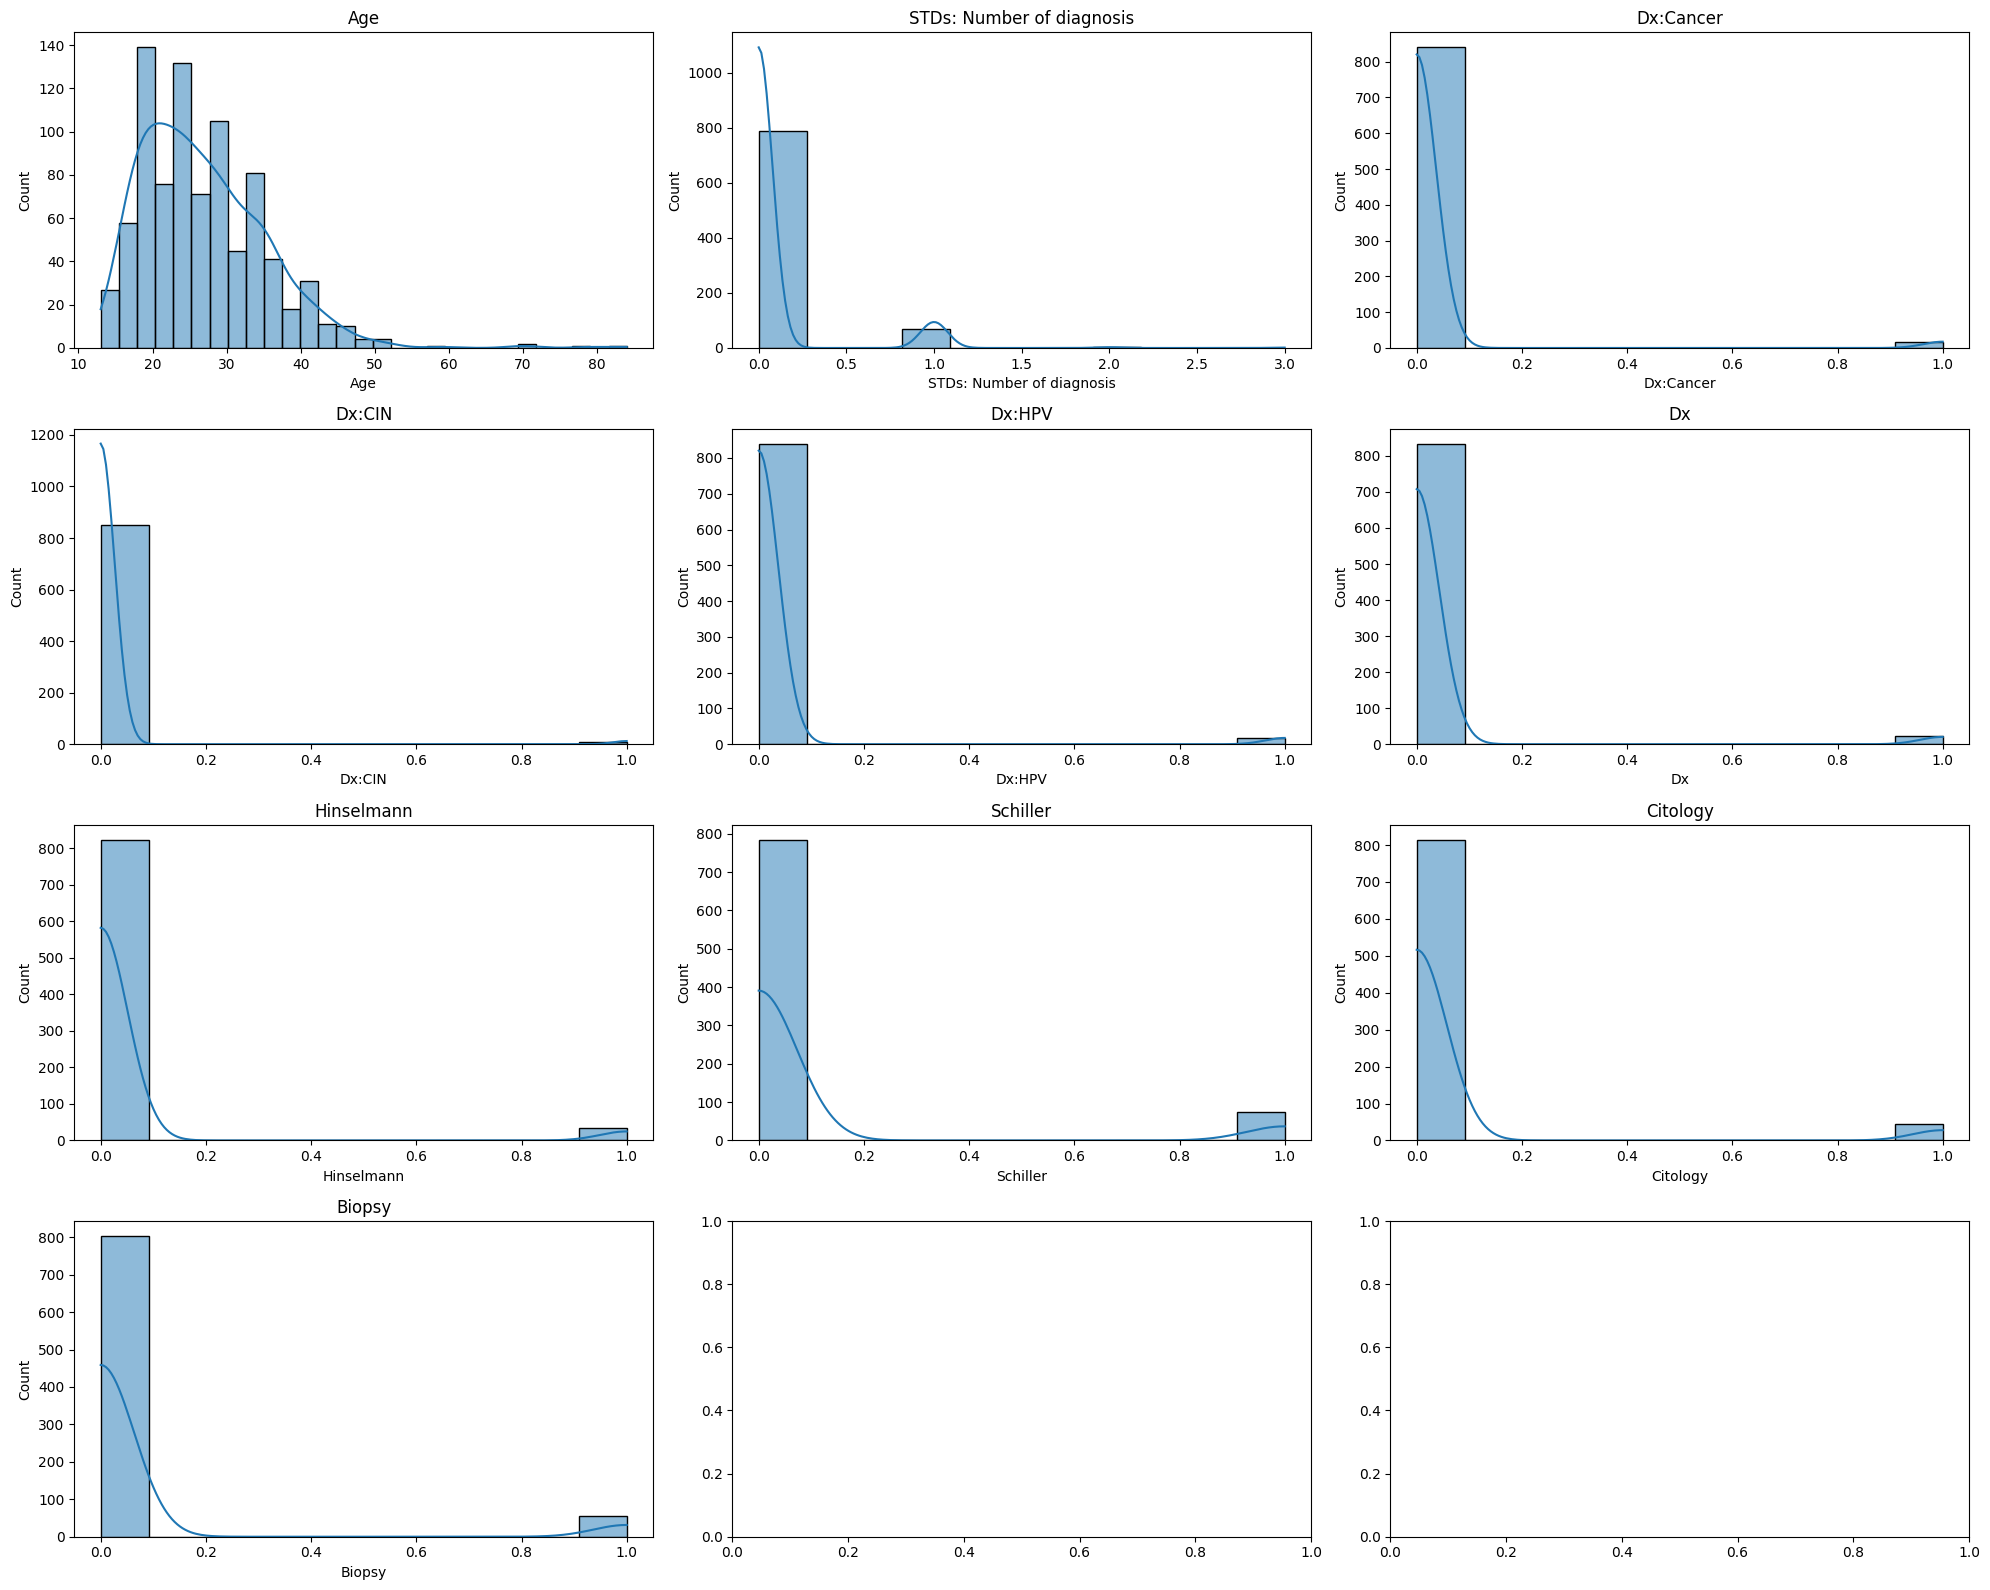

In [27]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(nrows=len(numeric_columns)//3 + 1, ncols=3, figsize=(20, 5*len(numeric_columns)//3))
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column].dropna(), ax=axes[i//3, i%3], kde=True)
    axes[i//3, i%3].set_title(column)
plt.tight_layout()
plt.show()

C:\Users\50242\AppData\Local\Temp\ipykernel_19804\1969364159.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\1969364159.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\1969364159.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\1969364159.py:16: UserWarning: set_ticklabels() should only be used with a fixed numbe

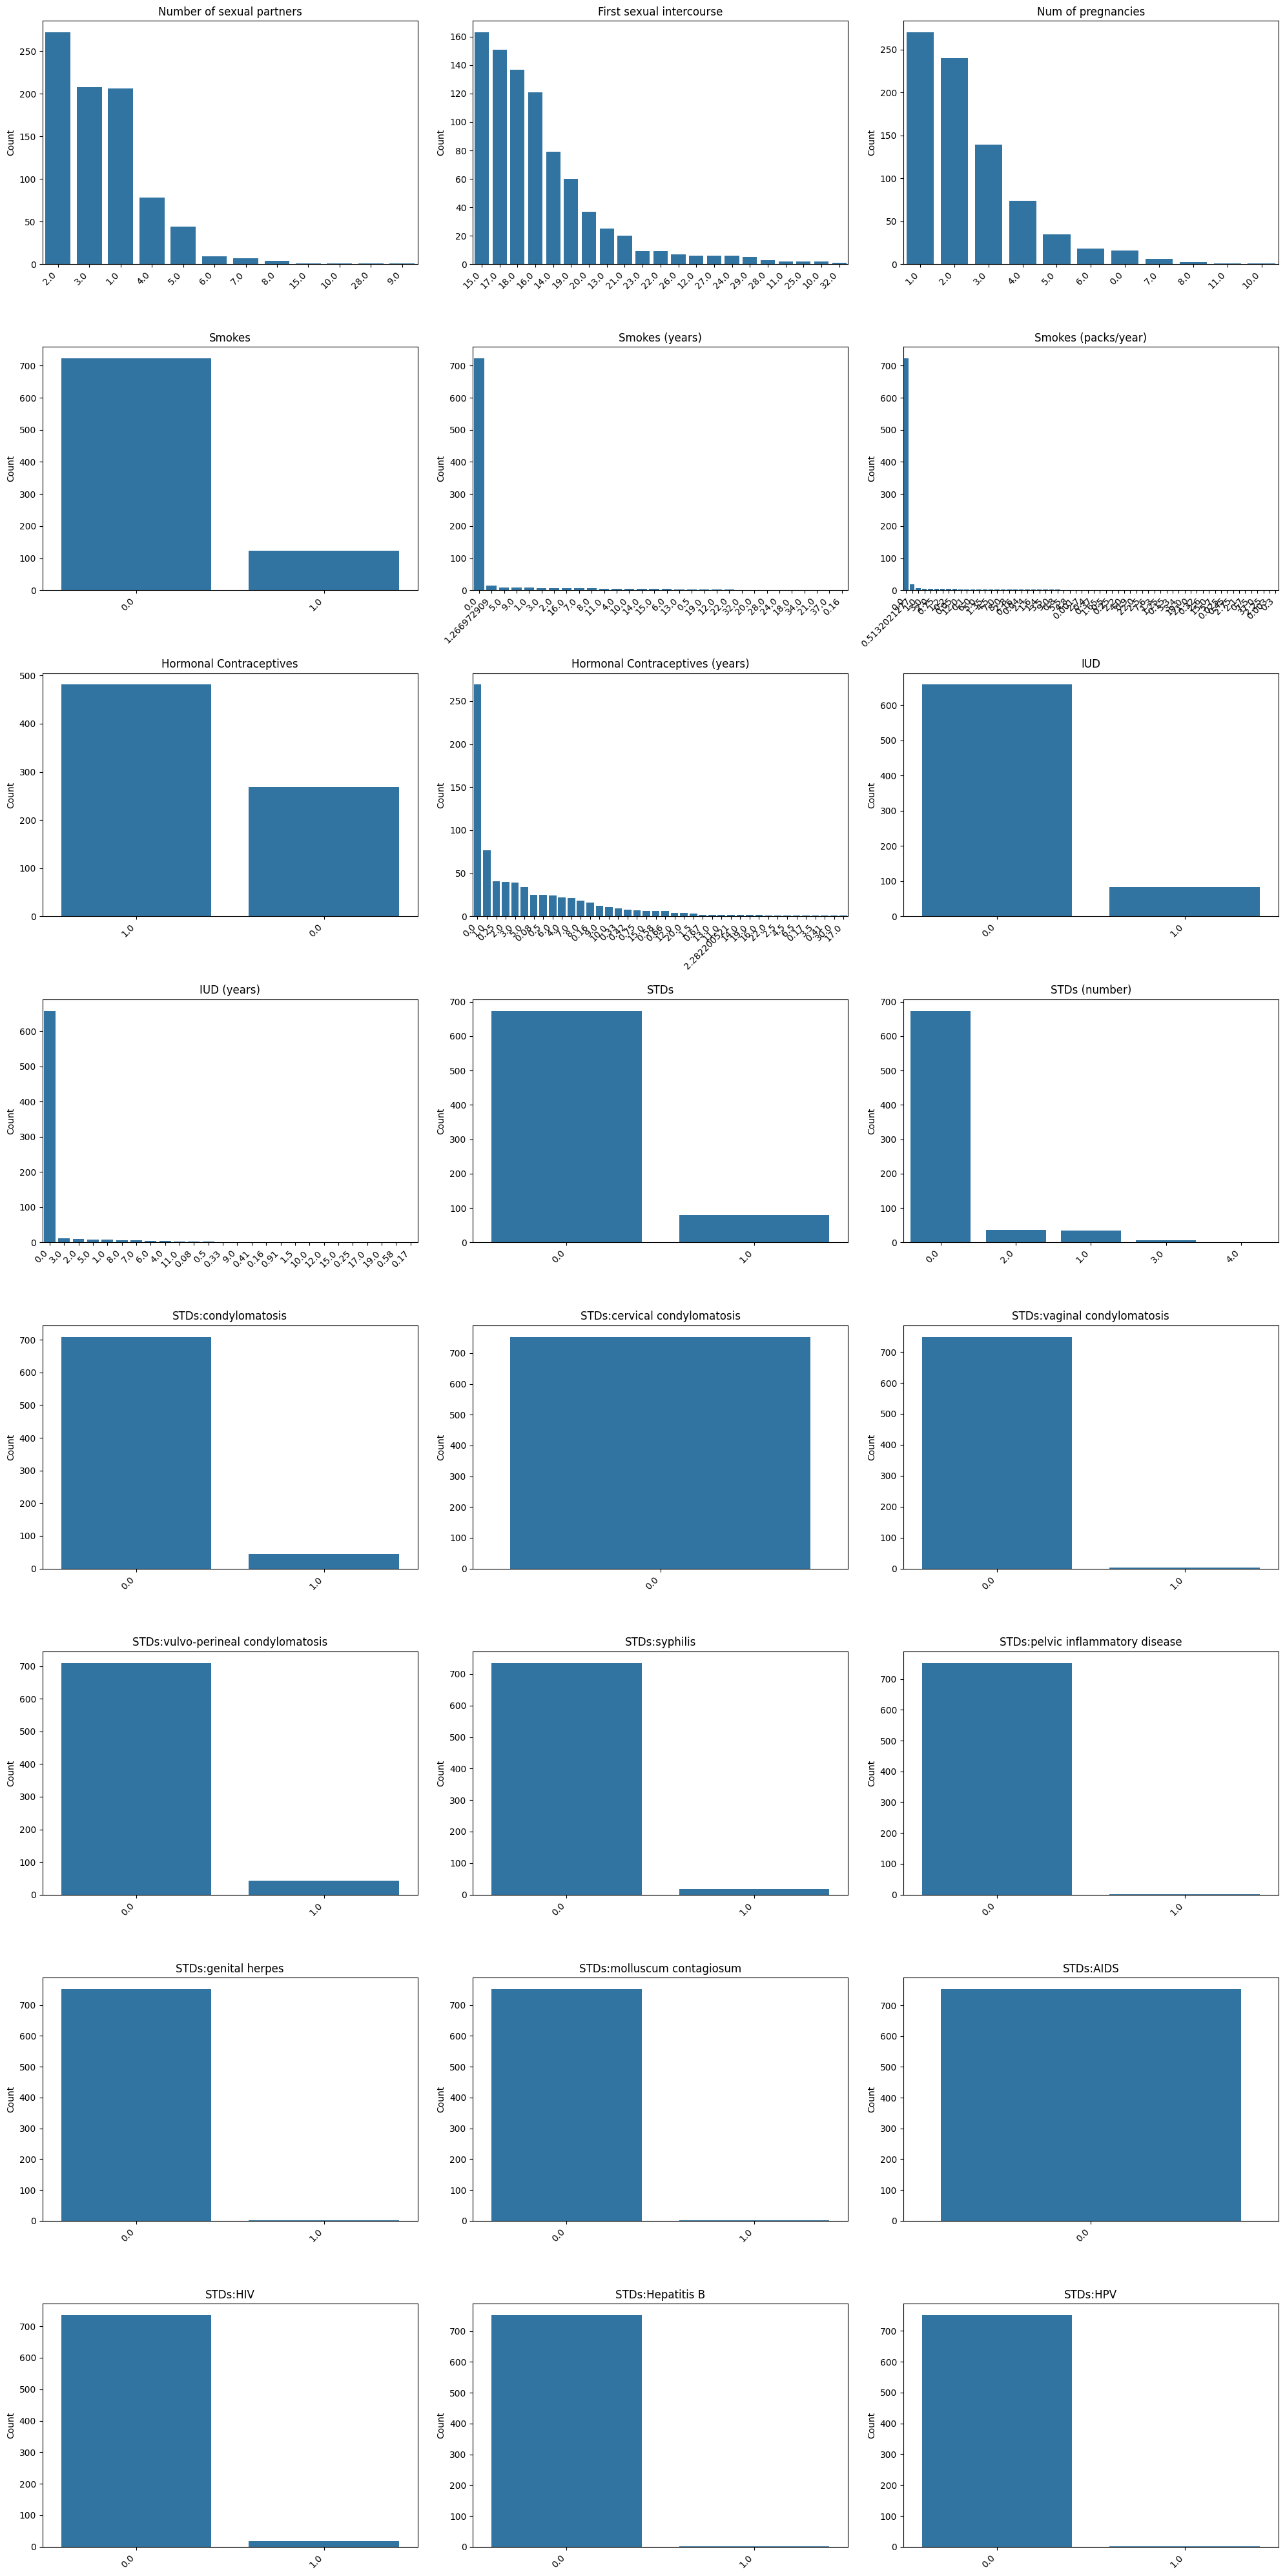

In [28]:
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
n_rows = len(categorical_columns) // 3 + (1 if len(categorical_columns) % 3 != 0 else 0)
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(20, 5*n_rows))

if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(categorical_columns):
    row = i // 3
    col = i % 3
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[row, col])
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 4. Matriz de correalacion

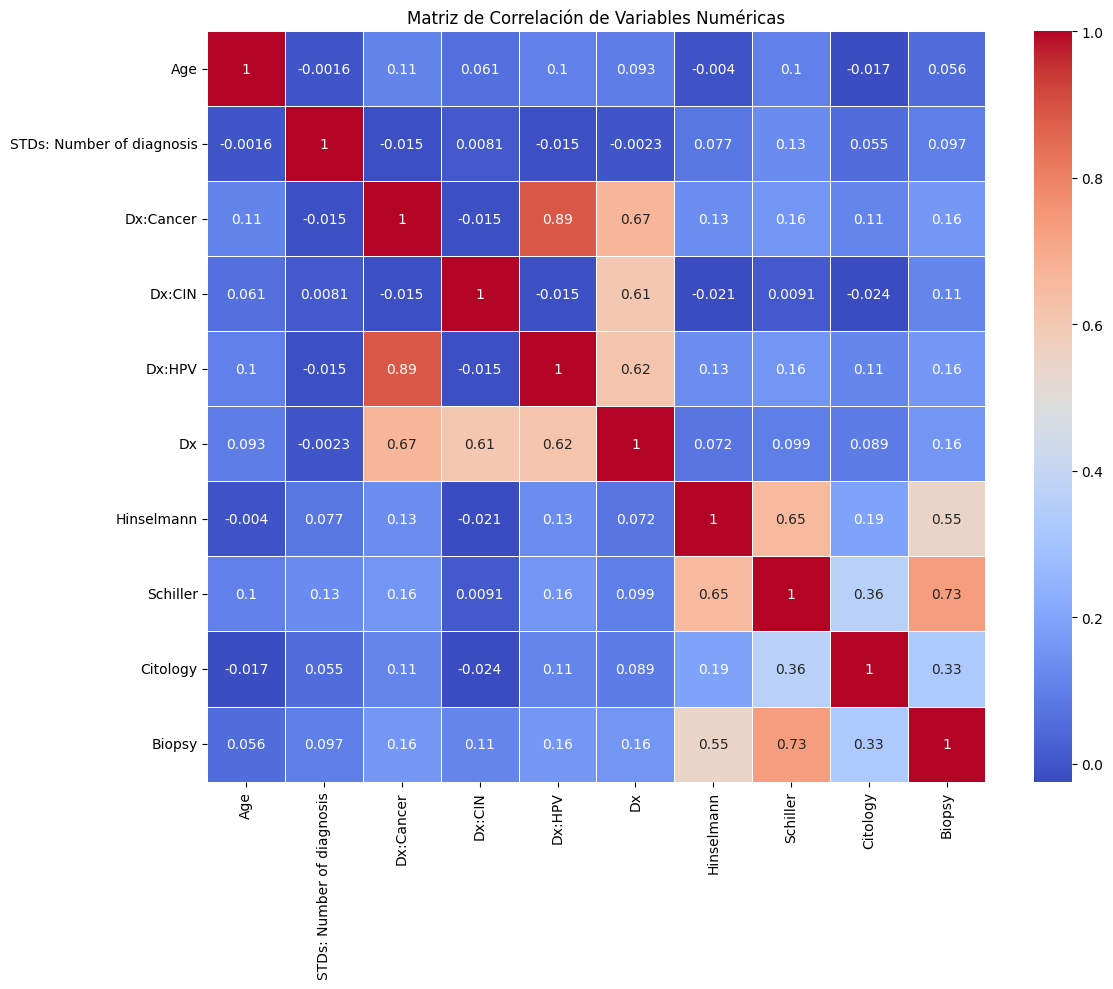

In [29]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

### 5. Tablas de frecuencia


Tabla de Frecuencia y Proporción para Number of sexual partners:
                           Frecuencia Proporción
Number of sexual partners                       
2.0                               272     32.69%
3.0                               208     25.00%
1.0                               206     24.76%
4.0                                78      9.38%
5.0                                44      5.29%
6.0                                 9      1.08%
7.0                                 7      0.84%
8.0                                 4      0.48%
15.0                                1      0.12%
10.0                                1      0.12%
28.0                                1      0.12%
9.0                                 1      0.12%

Tabla de Frecuencia y Proporción para First sexual intercourse:
                          Frecuencia Proporción
First sexual intercourse                       
15.0                             163     19.15%
17.0                             151   

C:\Users\50242\AppData\Local\Temp\ipykernel_19804\2275395182.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\2275395182.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\2275395182.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\50242\AppData\Local\Temp\ipykernel_19804\2275395182.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

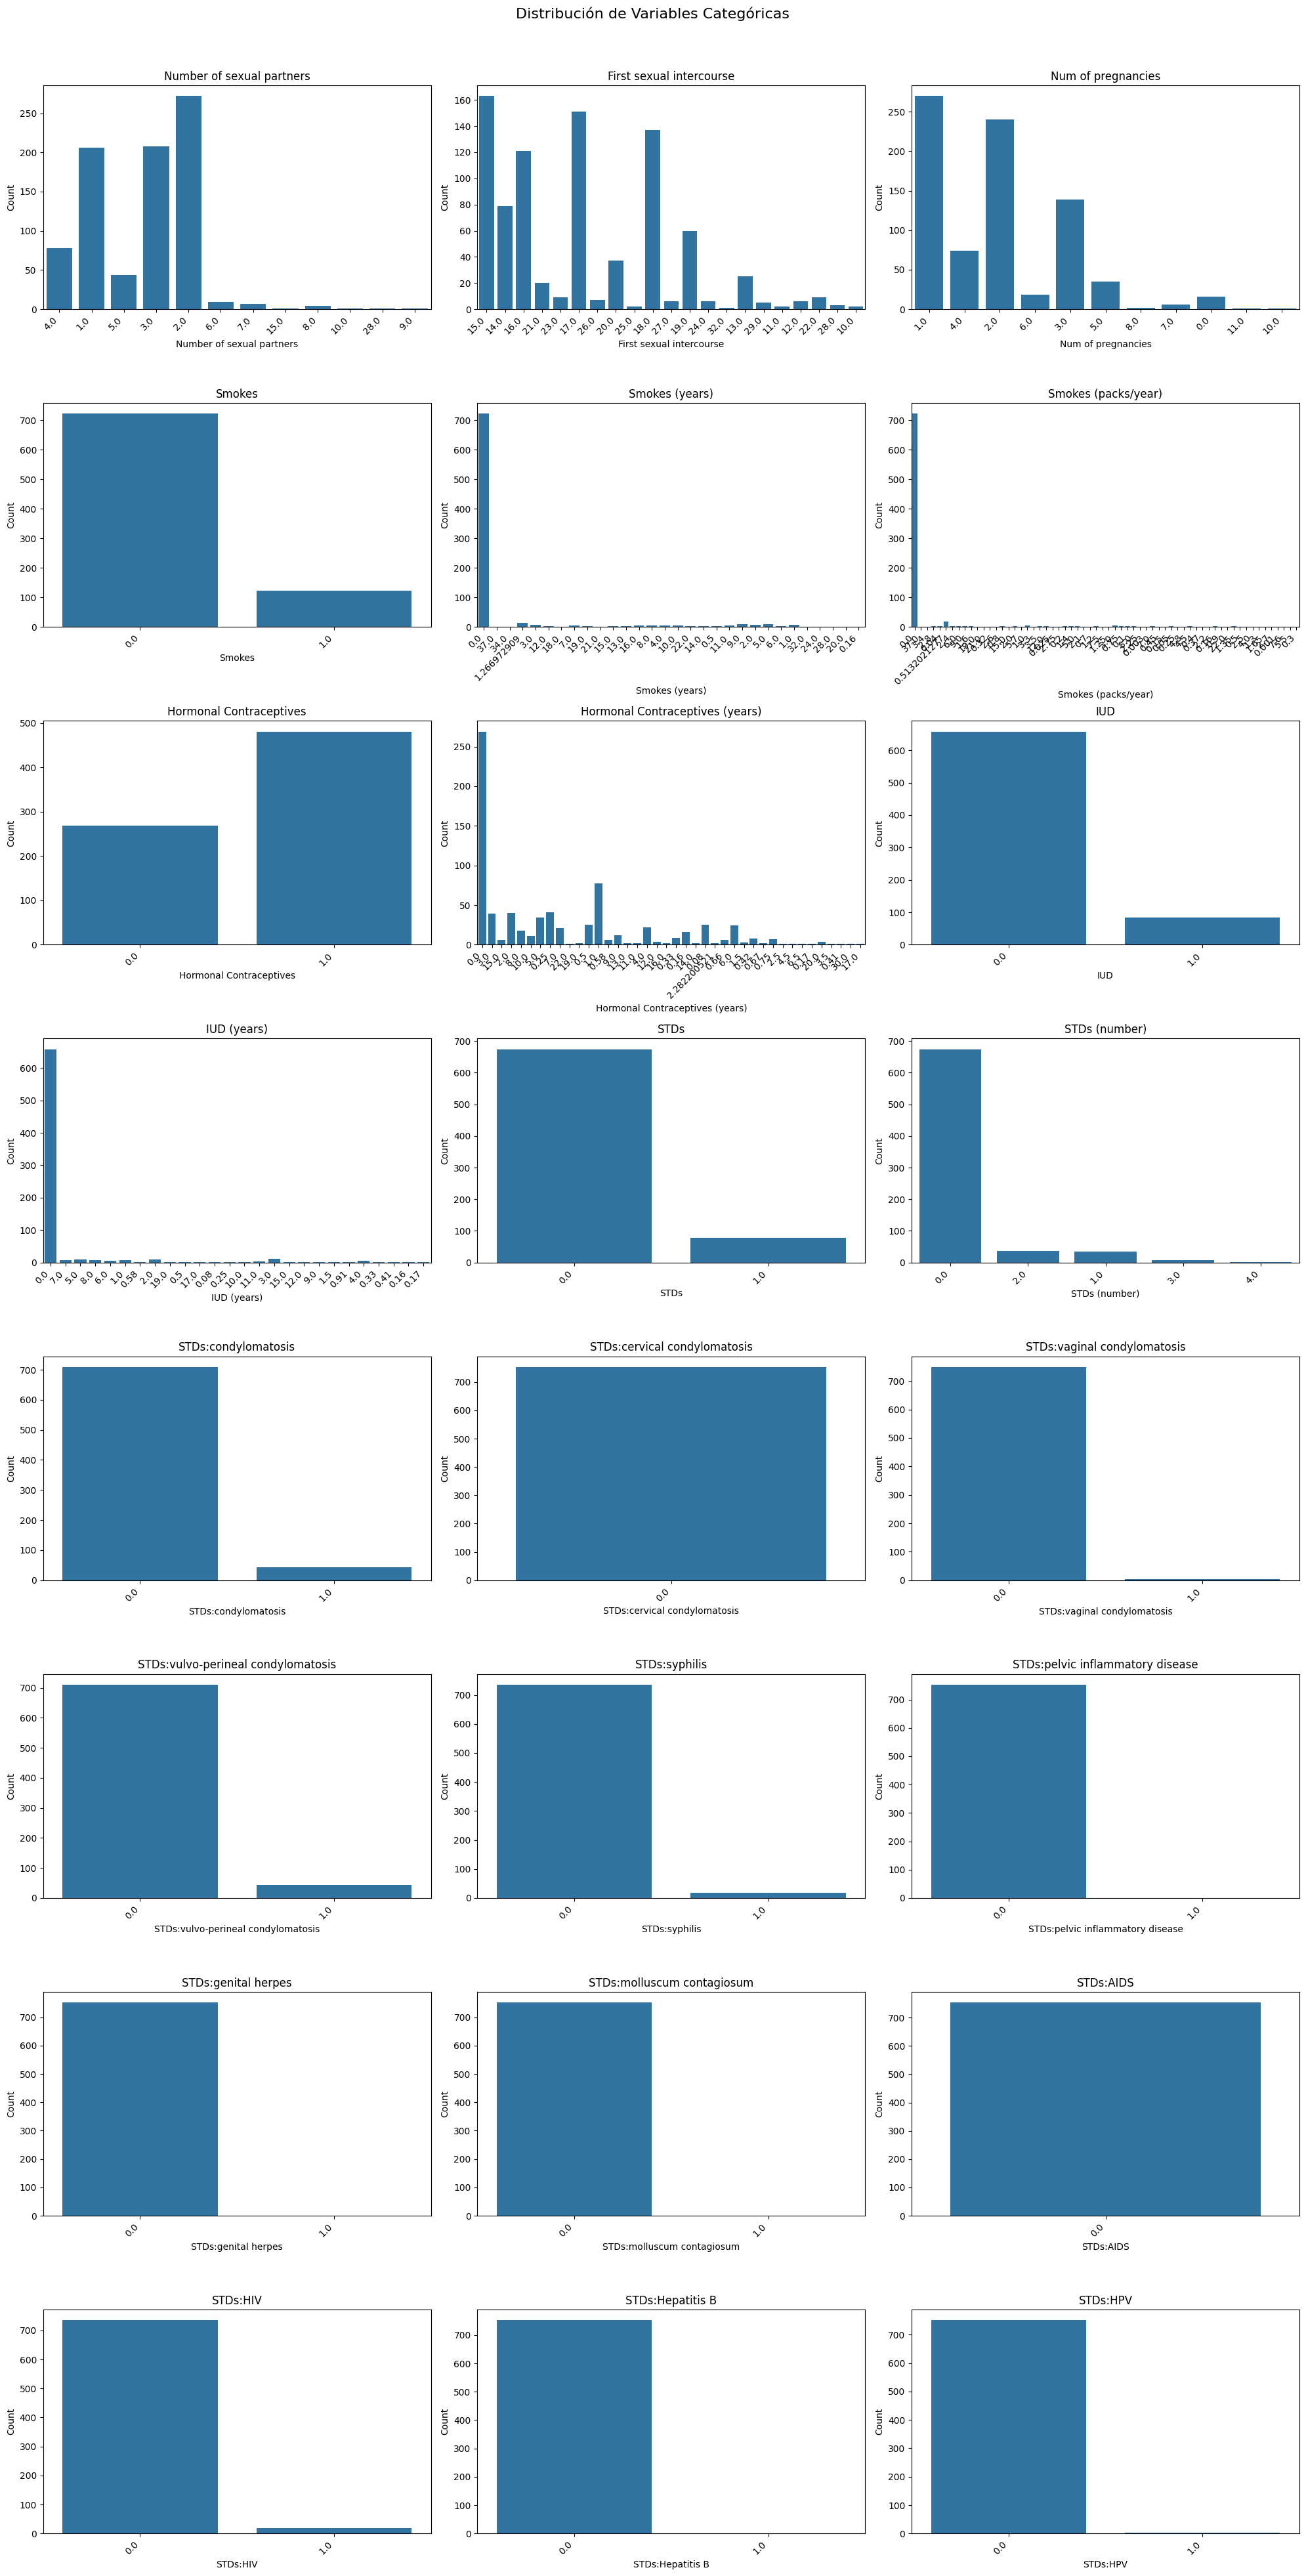

In [30]:
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns

def freq_prop_table(df, column):
    freq = df[column].value_counts()
    prop = df[column].value_counts(normalize=True)
    table = pd.concat([freq, prop], axis=1, keys=['Frecuencia', 'Proporción'])
    table['Proporción'] = table['Proporción'].map('{:.2%}'.format)
    return table

for column in categorical_columns:
    print(f"\nTabla de Frecuencia y Proporción para {column}:")
    table = freq_prop_table(df, column)
    print(table)

n_cols = 3
n_rows = (len(categorical_columns) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Categóricas', fontsize=16)

for i, column in enumerate(categorical_columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.countplot(x=column, data=df, ax=ax)
    ax.set_title(column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

### 7. Transformaciones en las variables categoricas

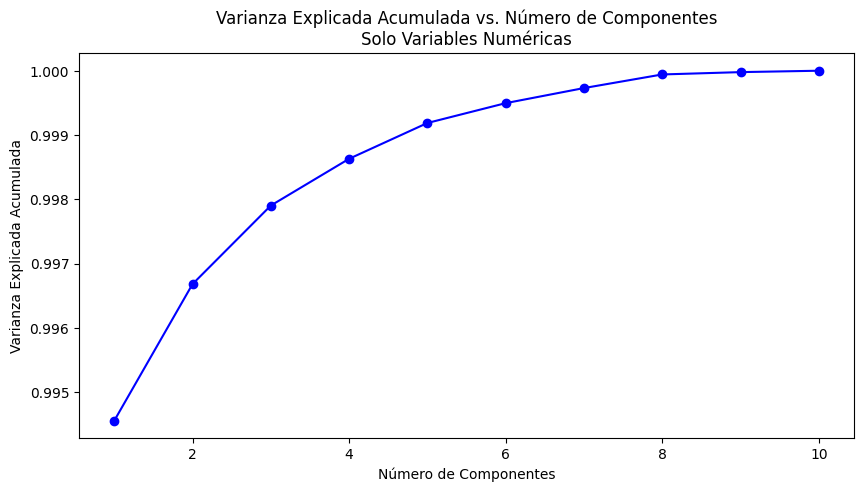


Solo Variables Numéricas:
Número de componentes para explicar el 95% de la varianza: 1
Dimensionalidad original del dataset: 10


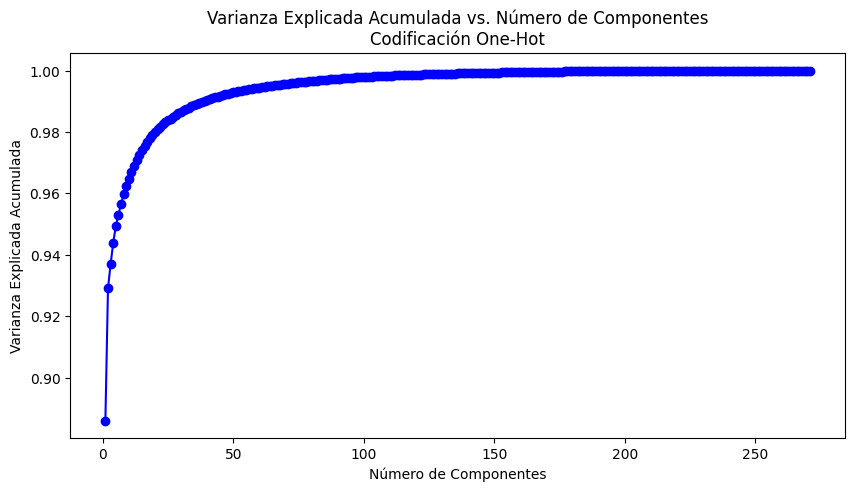


Codificación One-Hot:
Número de componentes para explicar el 95% de la varianza: 6
Dimensionalidad original del dataset: 271


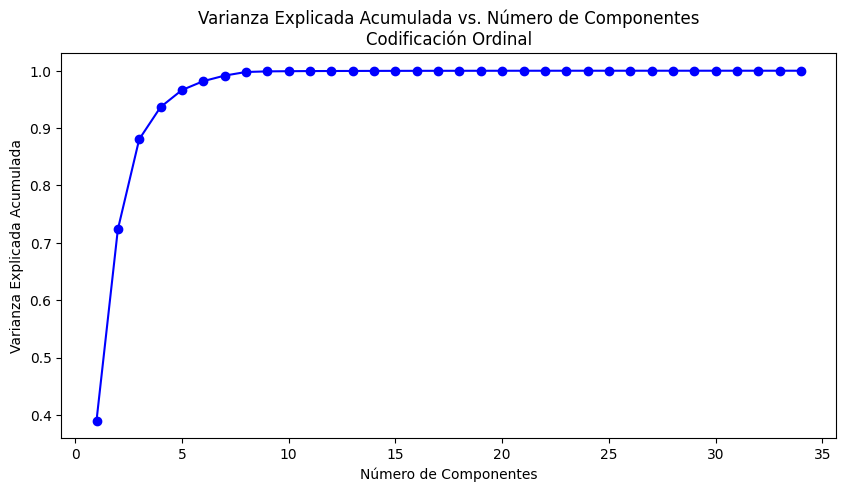


Codificación Ordinal:
Número de componentes para explicar el 95% de la varianza: 5
Dimensionalidad original del dataset: 34


In [31]:
def apply_one_hot_encoding(df, categorical_columns):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[categorical_columns])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns))
    return pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

def apply_ordinal_encoding(df, categorical_columns):
    encoder = OrdinalEncoder()
    df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
    return df

df_one_hot = apply_one_hot_encoding(df, categorical_columns)
df_ordinal = apply_ordinal_encoding(df.copy(), categorical_columns)

imputer = SimpleImputer(strategy='mean')
df_one_hot_imputed = pd.DataFrame(imputer.fit_transform(df_one_hot), columns=df_one_hot.columns)
df_ordinal_imputed = pd.DataFrame(imputer.fit_transform(df_ordinal), columns=df_ordinal.columns)

def perform_pca(df, title):
    pca = PCA()
    pca_result = pca.fit_transform(df)    
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.title(f'Varianza Explicada Acumulada vs. Número de Componentes\n{title}')
    plt.show()
    
    n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    print(f"\n{title}:")
    print(f"Número de componentes para explicar el 95% de la varianza: {n_components_95}")
    print(f"Dimensionalidad original del dataset: {df.shape[1]}")

perform_pca(df[numeric_columns], "Solo Variables Numéricas")
perform_pca(df_one_hot_imputed, "Codificación One-Hot")
perform_pca(df_ordinal_imputed, "Codificación Ordinal")

### 8. Análisis de componentes principales 


In [32]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmo_all, kmo_model = calculate_kmo(X_scaled)
print(f"Índice KMO: {kmo_model:.3f}")

chi_square_value, p_value = calculate_bartlett_sphericity(X_scaled)
print(f"Test de esfericidad de Bartlett:")
print(f"Chi-cuadrado: {chi_square_value:.3f}")
print(f"p-valor: {p_value:.3e}")

Índice KMO: 0.622
Test de esfericidad de Bartlett:
Chi-cuadrado: 4205.464
p-valor: 0.000e+00


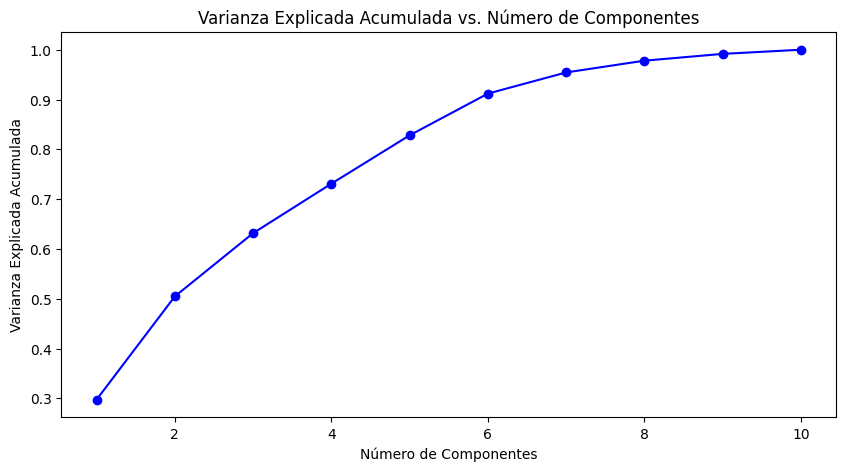

In [33]:
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs. Número de Componentes')
plt.show()

In [34]:
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNúmero de componentes para explicar el 95% de la varianza: {n_components_95}")

print("\nMatriz de componentes:")
component_matrix = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=numeric_columns)
print(component_matrix.head())


Número de componentes para explicar el 95% de la varianza: 7

Matriz de componentes:
                                PC1       PC2       PC3       PC4       PC5  \
Age                        0.096172  0.063629  0.066749  0.953882  0.116748   
STDs: Number of diagnosis  0.058166 -0.133496  0.097263 -0.125672  0.975464   
Dx:Cancer                  0.420256  0.367354 -0.326078 -0.028350  0.052869   
Dx:CIN                     0.134587  0.195407  0.805676 -0.070210 -0.073857   
Dx:HPV                     0.413238  0.356708 -0.339711 -0.031544  0.052149   

                                PC6       PC7       PC8       PC9      PC10  
Age                        0.208152  0.095495 -0.076324  0.010428  0.018555  
STDs: Number of diagnosis -0.011979  0.023771 -0.035745 -0.003541 -0.003615  
Dx:Cancer                 -0.045971 -0.031579 -0.004516  0.346077 -0.674989  
Dx:CIN                     0.016143  0.060057  0.022214 -0.357963 -0.389495  
Dx:HPV                    -0.049000 -0.047641 -0.

In [35]:
for i in range(n_components_95):
    print(f"\nComponente Principal {i+1}:")
    sorted_features = component_matrix[f'PC{i+1}'].abs().sort_values(ascending=False)
    for feature, value in sorted_features.items():
        if abs(value) > 0.3: 
            print(f"{feature}: {value:.3f}")


Componente Principal 1:
Dx:Cancer: 0.420
Dx:HPV: 0.413
Schiller: 0.392
Dx: 0.390
Biopsy: 0.389
Hinselmann: 0.332

Componente Principal 2:
Schiller: 0.422
Dx: 0.412
Hinselmann: 0.379
Biopsy: 0.369
Dx:Cancer: 0.367
Dx:HPV: 0.357

Componente Principal 3:
Dx:CIN: 0.806
Dx:HPV: 0.340
Dx:Cancer: 0.326
Dx: 0.308

Componente Principal 4:
Age: 0.954

Componente Principal 5:
STDs: Number of diagnosis: 0.975

Componente Principal 6:
Citology: 0.884
Hinselmann: 0.399

Componente Principal 7:
Hinselmann: 0.709
Biopsy: 0.630


### 9. Reglas de asociación 

In [36]:
relevant_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                    'Num of pregnancies', 'Smokes', 'Hormonal Contraceptives',
                    'IUD', 'STDs', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']
df = df[relevant_columns]

numeric_columns = df.select_dtypes(include=[np.number]).columns
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [37]:
for col in numeric_columns:
    df[f'{col}_disc'] = discretizer.fit_transform(df[[col]])
    df[f'{col}_disc'] = df[f'{col}_disc'].astype(int).astype(str)
    df[f'{col}_disc'] = col + '_' + df[f'{col}_disc']

c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider 

In [43]:
df_encoded = pd.get_dummies(df.drop(columns=numeric_columns))

min_support = 0.1
min_confidence = 0.8

frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True, max_len=3)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\nReglas con soporte mínimo {min_support} y confianza mínima {min_confidence}:")
print(f"Número de reglas encontradas: {len(rules)}")


Reglas con soporte mínimo 0.1 y confianza mínima 0.8:
Número de reglas encontradas: 2710


In [45]:
if len(rules) > 0:
    rules_sorted = rules.sort_values('lift', ascending=False).head(10)
    print("\nTop 10 reglas por lift:")
    for idx, rule in rules_sorted.iterrows():
        print(f"Regla: {list(rule['antecedents'])} -> {list(rule['consequents'])}")
        print(f"Soporte: {rule['support']:.3f}")
        print(f"Confianza: {rule['confidence']:.3f}")
        print(f"Lift: {rule['lift']:.3f}")
        print()


Top 10 reglas por lift:
Regla: ['Num of pregnancies_3.0', 'STDs_0.0'] -> ['Hormonal Contraceptives_1.0']
Soporte: 0.110
Confianza: 0.832
Lift: 1.484

Regla: ['Num of pregnancies_1.0', 'Hormonal Contraceptives_0.0'] -> ['IUD_0.0']
Soporte: 0.127
Confianza: 0.991
Lift: 1.292

Regla: ['Hormonal Contraceptives_0.0', 'Age_disc_Age_0'] -> ['IUD_0.0']
Soporte: 0.126
Confianza: 0.991
Lift: 1.292

Regla: ['Age_disc_Age_0', 'STDs_0.0'] -> ['IUD_0.0']
Soporte: 0.238
Confianza: 0.990
Lift: 1.291

Regla: ['Hormonal Contraceptives_1.0', 'Age_disc_Age_0'] -> ['IUD_0.0']
Soporte: 0.135
Confianza: 0.983
Lift: 1.282

Regla: ['Num of pregnancies_1.0', 'Hormonal Contraceptives_1.0'] -> ['IUD_0.0']
Soporte: 0.129
Confianza: 0.982
Lift: 1.281

Regla: ['Num of pregnancies_1.0', 'STDs_0.0'] -> ['IUD_0.0']
Soporte: 0.234
Confianza: 0.971
Lift: 1.266

Regla: ['Number of sexual partners_1.0', 'STDs_0.0'] -> ['IUD_0.0']
Soporte: 0.184
Confianza: 0.940
Lift: 1.226

Regla: ['Num of pregnancies_3.0', 'Hormonal Cont

In [40]:
cancer_rules = rules[rules['consequents'].apply(lambda x: 'Dx:Cancer_1.0' in x)]
print("\nReglas específicas para el diagnóstico de cáncer:")
for idx, rule in cancer_rules.iterrows():
    print(f"Regla: {list(rule['antecedents'])} -> {list(rule['consequents'])}")
    print(f"Soporte: {rule['support']:.3f}")
    print(f"Confianza: {rule['confidence']:.3f}")
    print(f"Lift: {rule['lift']:.3f}")
    print()


Reglas específicas para el diagnóstico de cáncer:
